In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
batch_size=32
image_size=256
channels = 3 
epochs =25 
dataset= tf.keras.utils.image_dataset_from_directory(directory="../PlantVillage",batch_size=batch_size, image_size=(image_size,image_size))

Found 2152 files belonging to 3 classes.


In [3]:
class_names=dataset.class_names

In [4]:
def  dataset_split(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle_size=10000):
    ds_size=len(ds)
    
    if shuffle_size:
        ds=ds.shuffle(shuffle_size,seed=42)
        
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    validation_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds ,validation_ds ,test_ds

In [5]:
train_ds , validation_ds ,test_ds=dataset_split(dataset)

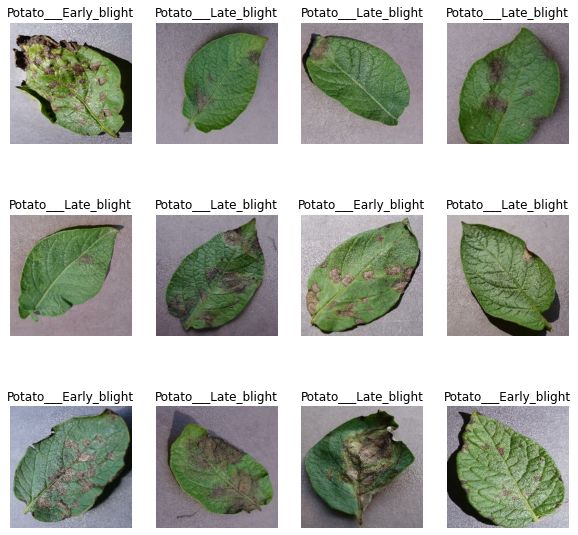

In [6]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [7]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=validation_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [8]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(image_size, image_size),
  layers.experimental.preprocessing.Rescaling(1./255)
])
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [9]:
input_size=(batch_size,image_size,image_size,channels)
model = tf.keras.models.Sequential([
    data_augmentation,
    layers.Conv2D(16,(3,3),activation="relu",input_shape=input_size),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(32,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(128,(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(3,activation="softmax")
])
model.build(input_shape=input_size)

In [10]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 32)         

In [11]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),metrics=["accuracy"])

In [12]:
history=model.fit(train_ds,epochs=epochs,batch_size=batch_size,verbose=1,validation_data=val_ds)

Epoch 1/25
54/54 [==============================] - 69s 1s/step - loss: 1.1418 - accuracy: 0.5405 - val_loss: 0.7046 - val_accuracy: 0.6510
Epoch 2/25
54/54 [==============================] - 61s 1s/step - loss: 0.5869 - accuracy: 0.7265 - val_loss: 0.5707 - val_accuracy: 0.7865
Epoch 3/25
54/54 [==============================] - 60s 1s/step - loss: 0.2943 - accuracy: 0.8862 - val_loss: 0.6035 - val_accuracy: 0.7448
Epoch 4/25
54/54 [==============================] - 60s 1s/step - loss: 0.2732 - accuracy: 0.9008 - val_loss: 0.2406 - val_accuracy: 0.8854
Epoch 5/25
54/54 [==============================] - 65s 1s/step - loss: 0.2081 - accuracy: 0.9196 - val_loss: 0.3530 - val_accuracy: 0.8750
Epoch 6/25
54/54 [==============================] - 61s 1s/step - loss: 0.2311 - accuracy: 0.9114 - val_loss: 0.1751 - val_accuracy: 0.9323
Epoch 7/25
54/54 [==============================] - 60s 1s/step - loss: 0.1666 - accuracy: 0.9390 - val_loss: 0.2259 - val_accuracy: 0.9062
Epoch 8/25
54/54 [==

In [13]:
model.evaluate(test_ds)

8/8 [==============================] - 4s 284ms/step - loss: 0.1481 - accuracy: 0.9492


[0.14810211956501007, 0.94921875]

In [14]:
#Matplotlib
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']
loss=history.history['loss']

Text(0.5, 1.0, 'Training and Validation loss')

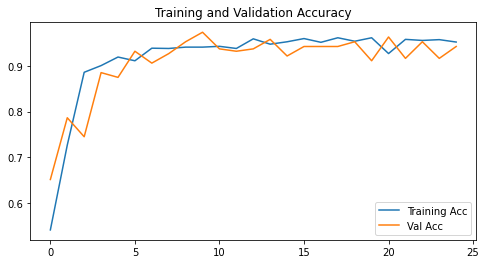

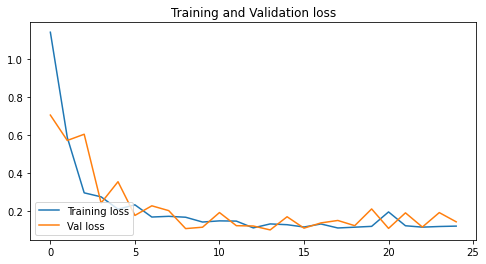

In [15]:
plt.figure(figsize=(8,4))
plt.plot(range(epochs),acc,label="Training Acc")
plt.plot(range(epochs),val_acc,label="Val Acc")
plt.legend(loc="lower right")
plt.title('Training and Validation Accuracy')
#============================================#
plt.figure(figsize=(8,4))
plt.plot(range(epochs),loss,label="Training loss")
plt.plot(range(epochs),val_loss,label="Val loss")
plt.legend(loc="lower left")
plt.title('Training and Validation loss')

Firrst image to predict
first image's actual label :  Potato___Early_blight
first image's predicted label :  Potato___Early_blight


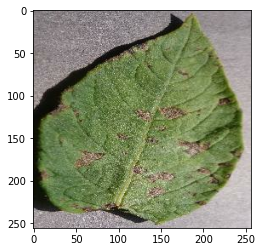

In [16]:
#Prediction
for images_batch,label_batch in test_ds.take(1):
    
    first_image= images_batch[0].numpy().astype('uint8')
    first_label= label_batch[0].numpy()
    
    print("Firrst image to predict")
    plt.imshow(first_image)
    print("first image's actual label : ",class_names[first_label])
    
    batch_predict=model.predict(images_batch)
    print("first image's predicted label : ",class_names[np.argmax(batch_predict[0])])

In [17]:
#function to predict 
def predict_name (model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) #create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    cofidence = round(100*(np.max(predictions[0])),2)
    return predicted_class , cofidence

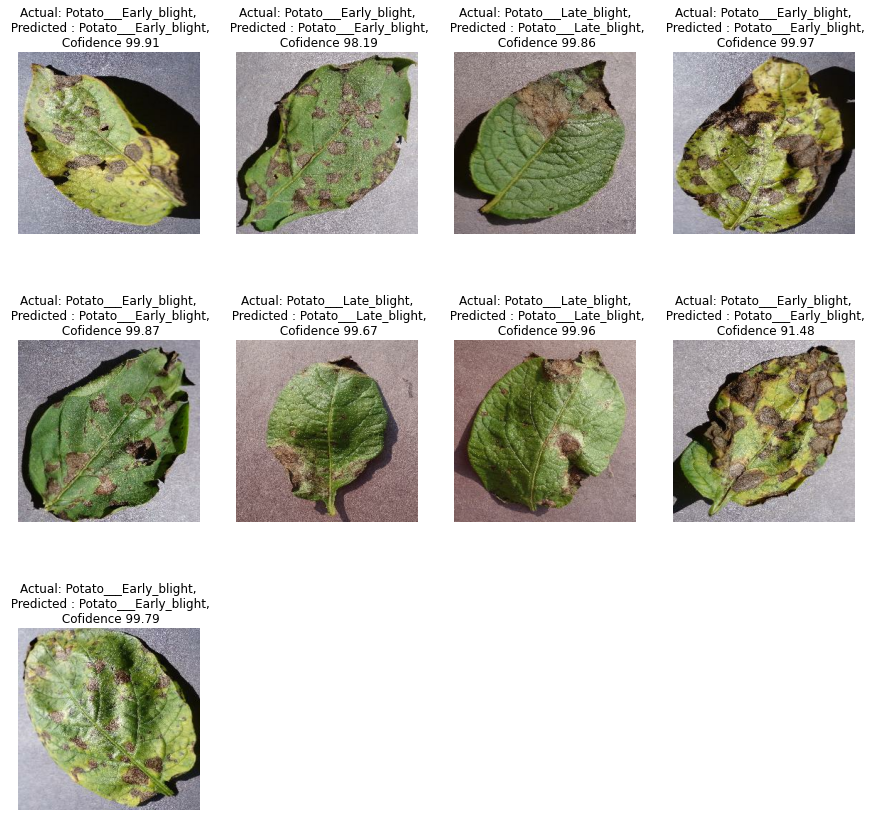

In [18]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):  
    for i in range(9):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")
        
        predicted_class,cofidence = predict_name(model,images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted : {predicted_class},\n Cofidence {cofidence}")

In [19]:
import os

In [20]:
os.getcwd()

'C:\\Users\\LENOVO\\Desktop\\Ambitious\\Training'

In [23]:
model_version=1
model.save(f"../Saved_Models/{model_version}")

INFO:tensorflow:Assets written to: ../Saved_Models/1\assets
